# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

import os
import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    return T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension

        # Load image paths
        self.image_files = glob('{}/*{}'.format(self.directory, extension))
    
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        # Construct the full path to the image file
        image_path = self.image_files[index]

        # Open the image file
        with Image.open(image_path).convert('RGB') as image:
            # Apply the transformations, if any
            if self.transforms is not None:
                image = self.transforms(image)

        return image 

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

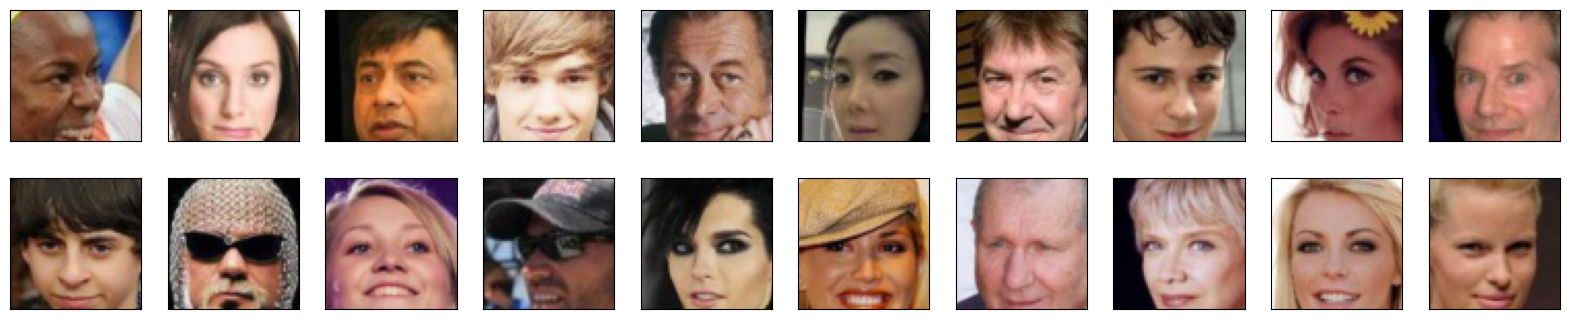

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
import torch.nn as nn

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        # Input size: [batch_size, 3, 64, 64]
        # the (first) conv. without batch normalization
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4,
                                     stride=2, padding=1, bias=False) # img_size = 64*64 => 3*64*64
        
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4,
                                     stride=2, padding=1, bias=False) # => 128*16*16
        self.batchNorm2 = torch.nn.BatchNorm2d(128)
        
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,
                                     stride=2, padding=1, bias=False) # => 256*8*8
        self.batchNorm3 = torch.nn.BatchNorm2d(256)

        self.conv4 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4,
                                     stride=2, padding=1, bias=False) # => 512*4*4
        
        self.batchNorm4 = torch.nn.BatchNorm2d(512)
        
        self.flatten = torch.nn.Flatten()
        
        self.fc = torch.nn.Linear(512*4*4, 1)
        
        self.LeakyReLU = torch.nn.LeakyReLU(0.3)

        self.dropout = torch.nn.Dropout(0.3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.batchNorm2(self.conv2(x)))
        x = self.LeakyReLU(self.batchNorm3(self.conv3(x)))
        x = self.LeakyReLU(self.batchNorm4(self.conv4(x)))

        x = self.flatten(x)
        x = self.dropout(self.fc(x))

        return x.view(1, 1, 1, -1)
        

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.deconv1 = torch.nn.ConvTranspose2d(in_channels=latent_dim, out_channels=512,
                                                kernel_size=4, stride=1, padding=0, bias=False)
        self.batchNorm1 = torch.nn.BatchNorm2d(512)
        
        self.deconv2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                                kernel_size=4, stride=2, padding=1, bias=False)
        self.batchNorm2 = torch.nn.BatchNorm2d(256)
        
        
        self.deconv3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                        kernel_size=4, stride=2, padding=1, bias=False)
        self.batchNorm3 = torch.nn.BatchNorm2d(128)
        
        
        self.deconv4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                kernel_size=4, stride=2, padding=1, bias=False)
        self.batchNorm4 = torch.nn.BatchNorm2d(64)

        # the (last) conv. without batch normalization
        self.deconv5 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3,
                                        kernel_size=4, stride=2, padding=1, bias=True)

        self.relu = torch.nn.ReLU() # for conv. layers (except the last)
        self.tanh = torch.nn.Tanh() # for the last conv. layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.relu(self.batchNorm1(self.deconv1(x)))
        x = self.relu(self.batchNorm2(self.deconv2(x)))
        x = self.relu(self.batchNorm3(self.deconv3(x)))
        x = self.relu(self.batchNorm4(self.deconv4(x)))
        
        x = self.tanh(self.deconv5(x))

        return x

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [13]:
import torch.optim as optim
from torch.nn import Module

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002

    betas = (0.5, 0.999)
    
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [14]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    return torch.mean(torch.log(1 - torch.sigmoid(fake_logits)))

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [15]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    # The size of the target tensor should match the size of the fake_logits tensor
    real_loss = torch.mean(torch.log(torch.sigmoid(real_logits)))
    fake_loss = torch.mean(torch.log(1 - torch.sigmoid(fake_logits)))
    return -(real_loss + fake_loss)

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [16]:
def gradient_penalty(discriminator, real_samples, fake_samples, device='cpu', lambda_gp=10):
    """ This function enforces """
    # TODO (Optional): implement the gradient penalty
    gp = 0
    # TODO (Optional): implement the gradient penalty    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [17]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    # Zero the gradients on the optimizer
    noise = torch.randn(batch_size, latent_dim, 1, 1)
    generated_images = generator(noise)
    fake_logits = discriminator(generated_images)
    g_loss = generator_loss(fake_logits)
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    # Zero the gradients on the optimizer
    noise = torch.randn(batch_size, latent_dim, 1, 1)
    generated_images = generator(noise)
    real_logits = discriminator(real_images)
    fake_logits = discriminator(generated_images.detach())

    d_loss = discriminator_loss(real_logits, fake_logits)

    # Gradient Penalty (Optional, for WGAN-GP)
    epsilon = torch.rand(batch_size, 1, 1, 1)
    interpolated_images = epsilon * real_images + (1 - epsilon) * generated_images
    interpolated_logits = discriminator(interpolated_images)
    gradients = grad(outputs=interpolated_logits, inputs=interpolated_images, grad_outputs=torch.ones_like(interpolated_logits), create_graph=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    d_loss += lambda_gp * gradient_penalty

    return {'loss': d_loss, 'gp': gradient_penalty.item()}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [18]:
from datetime import datetime

In [20]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [ ]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        # Training the Discriminator
        ####################################
        
        discriminator.zero_grad()

        # Real images
        real_labels = torch.ones(real_images.size(0)).to(device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output.squeeze(), real_labels)
        d_loss_real.backward()

        # Fake images
        latent_vector = torch.randn(real_images.size(0), latent_dim, 1, 1).to(device)
        fake_images = generator(latent_vector)
        fake_labels = torch.zeros(real_images.size(0)).to(device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output.squeeze(), fake_labels)
        d_loss_fake.backward()

        # Update the discriminator
        d_loss = d_loss_real + d_loss_fake
        optimizer_discriminator.step()
        
        ####################################
        # Training the Generator
        ####################################
        
        generator.zero_grad()

        # Generate fake images and calculate generator loss
        fake_labels_gen = torch.ones(real_images.size(0)).to(device)
        fake_output_gen = discriminator(fake_images)
        g_loss = criterion(fake_output_gen.squeeze(), fake_labels_gen)
        g_loss.backward()

        # Update the generator
        optimizer_generator.step()

        ####################################
        
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    with torch.no_grad():
        generator.eval()
        generated_images = generator(fixed_latent_vector).detach().cpu()
        display(generated_images)
        generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

In [ ]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

Analyzing the generated samples from a GAN trained on a dataset of "celebrity" faces, primarily of white ethnicity, reveals some insights into the model's performance and areas for improvement. The quality and diversity of the generated images can be influenced by several factors, including dataset bias, model size, optimization strategy, and loss functions.

Dataset Bias: The bias towards mostly white celebrity faces in the dataset may lead to a lack of diversity in the generated samples. The model may struggle to generate faces of varied ethnicities accurately due to the limited representation in the training data. To improve diversity and representation in the generated images, it's crucial to use a more balanced dataset that includes faces from a wide range of ethnic backgrounds. Augmenting the current dataset with additional images or using a pre-existing diverse dataset can help the model learn a broader spectrum of facial features.

Model Size: The capacity of the model to learn and represent complex features in the data is directly related to its size. Larger models, with more layers and parameters, can capture more detailed and nuanced features in the dataset. However, larger models also require more computational resources and may be prone to overfitting if not properly regularized. To improve the quality of generated samples, consider experimenting with larger model architectures while employing techniques like dropout, batch normalization, or adding noise to inputs during training to prevent overfitting.

Optimization Strategy: The choice of optimizers (e.g., Adam, RMSprop) and the number of training epochs significantly affect the model's performance. Different optimizers have different ways of adjusting the learning rate and handling the gradient descent process, which can lead to variations in the training dynamics and final output quality. It may be beneficial to experiment with different optimizers and learning rate schedules to find an optimal configuration. Additionally, the number of epochs should be chosen to allow sufficient learning without causing overfitting. Early stopping can be implemented to halt training when the validation loss stops decreasing.

Loss Functions: The choice of loss functions for both the generator and discriminator plays a critical role in guiding the training process and ensuring that generated samples are both realistic and diverse. Exploring alternative loss functions, such as Wasserstein loss with gradient penalty or least squares GAN (LSGAN) loss, might lead to improvements in the stability of training and the quality of the generated images. These alternative loss functions can help in mitigating issues like mode collapse and encourage the generation of more varied samples.

Improving the model based on these considerations involves a careful balance of dataset augmentation, model architecture tuning, optimization strategy refinement, and experimentation with different loss functions. Regular evaluation of generated samples against a diverse set of criteria, including realism, diversity, and adherence to input conditions (if any), will guide the iterative improvement process.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.